# THE CHALLENGE

Describe the challenge

## Preliminaries
### Import modules and set defaults

In [1]:
import matplotlib.pyplot as plt
import seaborn           as sbn
import pandas            as pd
import scipy.stats       as sts
import numpy             as np

%matplotlib notebook

### Define some functions for later use

#### Pairwise corrected binomial test among multiple labeled groups within one dataframe

In [2]:
import statsmodels.api as sm

def bool_groups(x, groups, data, alpha=0.05, method='hs'):
    
    labels = data[groups].unique()
    
    n_grps = len(labels)
    
    results = pd.DataFrame(columns=['group1', 'group2', 'pval', 'pval_corr', 'reject'])
    
    for i in range(n_grps):
        
        mask_i = data[groups] == labels[i]
        grp_i = data[mask_i][x]
        
        for j in range(i+1, n_grps):
            
            mask_j = data[groups] == labels[j]
            grp_j = data[mask_j][x]
            
            ct = ([[grp_i.sum(), grp_j.sum()], [grp_i.count() - grp_i.sum(), grp_j.count() - grp_j.sum()]])
            pval = sts.fisher_exact(ct)[1]
            
            row = results.shape[0] + 1
            
            results.loc[row, 'group1'] = labels[i]
            results.loc[row, 'group2'] = labels[j]
            results.loc[row, 'pval'] = pval
    
    
    results.pval_corr = sm.stats.multipletests(results.pval, alpha=alpha, method=method)[1]
    results.reject = sm.stats.multipletests(results.pval, alpha, method)[0]
    
    return results

#### Welch one-way ANOVA

In [3]:
from collections import namedtuple
from math        import floor, ceil

def welch_anova(*sample):
    
    k = len(sample)

    weights = np.asarray([sample[i].count() / sample[i].var() for i in range(k)])
    w_means = np.asarray([sample[i].mean() * weights[i] for i in range(k)])
    
    a_i = np.asarray([weights[i] * (sample[i].mean() - w_means.sum() / weights.sum())**2 for i in range(k)])
    b_i = np.asarray([(1 - (weights[i] / weights.sum()))**2 / (sample[i].count() - 1) for i in range(k)])
    
    df_ag = k - 1
    df_wg = (k**2 - 1) / (3 * b_i.sum())
    
    Fpp_stat = (a_i.sum() / (k - 1)) / (1 + 2 * ((k - 2) / (k**2 - 1)) * b_i.sum())
    
    p_low = sts.f.sf(Fpp_stat, df_ag, floor(df_wg))
    p_high = sts.f.sf(Fpp_stat, df_ag, ceil(df_wg))
  
    p_value = p_low + (p_high - p_low) * (df_wg % 1)
    
    results = namedtuple('WelchAnovaResult', ('F_statistic', 'p_value'))
    
    return results(Fpp_stat, p_value)

#### Games-Howell posthoc test

In [4]:
from statsmodels.stats.libqsturng import qsturng
from math                         import sqrt

def games_howell(*sample, alpha=0.05):
    
    k = len(sample)
    
    results = pd.DataFrame(index=range(k), columns=range(k))
    np.fill_diagonal(results.values, '-')
    
    for i in range(k):
        for j in range(i + 1, k):
            df = (((sample[i].var() / sample[i].count()) + (sample[j].var() / sample[j].count()))**2 /
                 (((sample[i].var() / sample[i].count())**2 / (sample[i].count() - 1)) +
                  ((sample[j].var() / sample[j].count())**2 / (sample[j].count() - 1))))
    
            qcrit = qsturng(1 - alpha, k, df)
    
            msd = qcrit * sqrt((sample[i].var() / sample[i].count() + sample[j].var() / sample[j].count()) / 2)
    
            md = abs(sample[i].mean() - sample[j].mean())
            
            sgnf = md > msd
        
            results.iat[j, i] = sgnf
            results.iat[i, j] = str('%.3E' % md) + ' | ' + str('%.3E' % msd)
    
    return results 

## Read Data

### Define data file

In [5]:
excel_file_name = "ChallengeData.xls.xlsx"

### Import raw data

In [6]:
user_data  = pd.read_excel(excel_file_name, 0)
sales_data = pd.read_excel(excel_file_name, 1)

del excel_file_name

### Look at the data

In [7]:
user_data.head()

,userid,cohort,has_first_name,has_last_name,has_verfied_email,has_phone,number_of_items_watched
0,1101,c,False,True,False,False,0
1,1105,a,True,True,False,True,1
2,1109,c,True,True,True,False,10
3,1118,a,True,False,False,False,0
4,1135,c,True,True,True,False,5


In [8]:
sales_data.head()

,userid,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15,Unnamed: 16,Unnamed: 17
0,1101,0,0,4,1,1,0,0,2,0,0,0,1,0,0,1,NaN,Each cell shows the number of antibody purchas...
1,1105,6,5,3,4,4,2,0,0,1,0,3,3,0,0,1,NaN,NaN
2,1109,0,0,4,3,4,0,1,1,0,0,1,0,0,0,0,NaN,NaN
3,1118,0,2,3,5,0,0,0,2,1,0,3,3,0,0,0,NaN,NaN
4,1135,0,0,4,3,0,3,0,1,0,2,0,1,0,1,2,NaN,NaN


### Drop last two columns from weekly sales files because they contain only a comment

In [9]:
sales_data.drop(sales_data.columns[[16, 17]], axis=1, inplace=True)

### Shorten the column names a bit so we have to type less

In [10]:
user_data.rename(columns={                  'userid': 'ud', 
                                    'has_first_name': 'hfn', 
                                     'has_last_name': 'hln', 
                                 'has_verfied_email': 'hve', 
                                         'has_phone': 'hph', 
                           'number_of_items_watched': 'niw'}, inplace=True)
sales_data.rename(columns=lambda x: x[0] + x[5:], inplace=True)

## Check the Data

### Are the _userid_ columns the same for user and weekly sales data?

In [11]:
user_data.ud.equals(sales_data.ud)

True

### Good! Let's add a column with total sales and merge the two datasets

In [12]:
user_data['tot'] = sales_data.loc[:, 'w1':].sum(axis=1)
full_data = user_data.merge(sales_data, on='ud', left_index=True, right_index=True)

del user_data
del sales_data

### Are there any missing values in the data?

In [13]:
full_data.isnull().any()

ud        False
cohort    False
hfn       False
hln       False
hve       False
hph       False
niw       False
tot       False
w1        False
w2        False
w3        False
w4        False
w5        False
w6        False
w7        False
w8        False
w9        False
w10       False
w11       False
w12       False
w13       False
w14       False
w15       False
dtype: bool

### No? Good! Are there any duplicate user IDs?

In [14]:
print('This number should be 1.0: ', full_data.ud.unique().size / full_data.ud.count())

This number should be 1.0:  0.948


### They are. So let's look at the duplicates and see what is going on

In [15]:
is_userid_duplicate = full_data.duplicated('ud', keep=False)

full_data[is_userid_duplicate].head(10)

,ud,cohort,hfn,hln,hve,hph,niw,tot,w1,w2,...,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
18,1267,a,True,False,True,False,0,29,0,5,...,4,0,1,0,1,0,3,2,1,3
19,1267,c,True,True,False,False,0,10,0,0,...,3,0,2,0,0,0,0,2,0,0
25,1313,a,True,True,False,False,0,26,1,5,...,0,3,0,0,0,3,2,2,2,0
26,1313,a,True,True,False,False,3,22,0,0,...,0,3,2,3,1,3,1,0,0,0
77,1787,a,True,True,False,False,0,17,0,2,...,3,3,1,0,0,0,2,2,2,0
78,1787,a,True,True,True,False,0,16,6,1,...,0,0,3,0,0,0,0,2,0,0
79,1787,b,True,True,True,False,0,25,1,0,...,4,0,1,0,3,0,3,0,0,3
112,2073,a,False,True,False,False,17,26,0,4,...,3,0,3,1,0,0,1,0,0,3
113,2073,b,False,True,True,True,6,43,0,3,...,5,0,1,7,3,1,6,2,5,3
116,2100,b,True,True,False,True,0,35,0,4,...,4,0,7,0,6,2,2,0,2,0


#### This makes no sense! The same userid is in different cohorts, has different user details, looks at and buys a different amount of stuff. Three scenarios are conceivable:
1. There has been a major cockup in collecting user data (a minor one for sure).
2. Each userid indeed refers to a unique customer.
3. Each _row_ in the table refers to a unique customer.

#### Since we cannot ask the person or persons unkown who collected the data, we cannot follow up on (1). Best to discard the duplicates then, just to be on the safe side. On the other hand, we would like to have as many data points as possible to improve statistics. Therefore, we will assert (in good faith) that there was, in fact, no _major_ cockup. In that case, we can potentially differentiate (2) and (3):
#### If the userid were unique, then treating each _row_ as individual user would yield a _total_-sales distribution with a mean at least half (or a third or even less) that of the mean of the non-duplicate users. If, however, treating each row as individual customer yields a total-sales distribution similar to that of the non-duplicate users, then each row might, in fact, represent a unique user.

#### Let's see ...

### Pull out the duplicates and and create complementary dataset

In [16]:
full_dups = full_data[is_userid_duplicate]
full_rest = full_data.drop_duplicates('ud', keep=False)

### Compare descriptive statistics

In [17]:
print('REGULARS')
print(full_rest.tot.describe(),'\n')
print('DUPLICATES')
print(full_dups.tot.describe())

REGULARS
count    898.000000
mean      19.714922
std        8.593964
min        2.000000
25%       13.000000
50%       19.000000
75%       25.000000
max       50.000000
Name: tot, dtype: float64 

DUPLICATES
count    102.000000
mean      20.715686
std        8.393040
min        7.000000
25%       14.000000
50%       20.000000
75%       26.000000
max       48.000000
Name: tot, dtype: float64


### Hmm. Seems quite similar. Let's look at the histogramms.

<IPython.core.display.Javascript object>


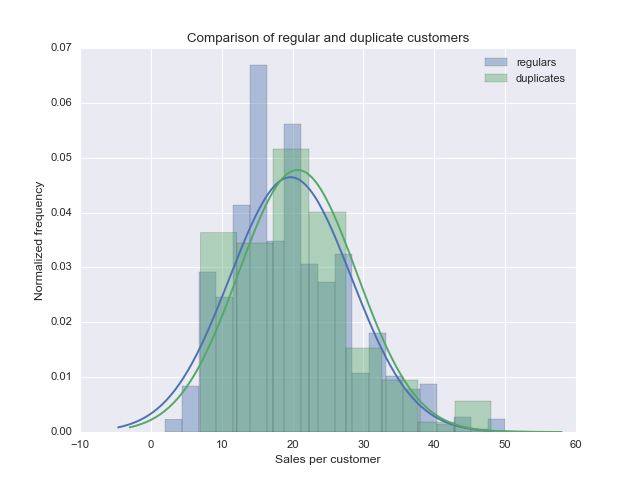

In [18]:
dups_fig = plt.figure(1)

dups_axis = sbn.distplot(full_rest.tot, kde=False, fit=sts.norm, fit_kws={'color': '#4c72b0'}, label='regulars')
sbn.distplot(full_dups.tot, kde=False, fit=sts.norm, fit_kws={'color': '#55a868'}, label='duplicates')

dups_axis.set_xlabel('Sales per customer')
dups_axis.set_ylabel('Normalized frequency')
dups_axis.set_title('Comparison of regular and duplicate customers')
dups_axis.legend();

#### Also looks quite similar. But is the tiny difference maybe statistically significant? To test for this, we first need to decide on a _way_ of testing statistical significance, because different tests make different assumptions about the respective populations underlying the samples to be compared:
* We are primarily interested in whether the _means_ of the two populations are truly different.
* Which test to use for the difference in means depends on whether the _variance_ of the two samples differs or not.
* Which test to use for the difference in varicance depends on whether the sample distributions are _Gaussian_ or not.

#### So the order of statistical significance tests is:
1. Normailty
2. Uniformity of variance
3. DIfference in means

### Check for normality

#### Let's first visualize the data in Q-Q plots

<IPython.core.display.Javascript object>


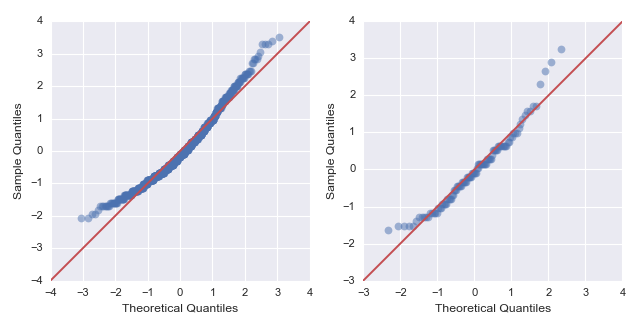

In [19]:
dups_norm_QQfig = plt.figure(2, figsize=(8, 4))

QQrest_axis = dups_norm_QQfig.add_subplot(121, aspect=1.0)
QQdups_axis = dups_norm_QQfig.add_subplot(122, aspect=1.0)

sm.qqplot(full_rest.tot, dist=sts.norm, fit=True, line='45', ax=QQrest_axis)
sm.qqplot(full_dups.tot, dist=sts.norm, fit=True, line='45', ax=QQdups_axis)

lines = dups_norm_QQfig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
dots  = dups_norm_QQfig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[l.set_color('#c44e52') for l in lines]
[d.set_color('#4c72b0') for d in dots ]
[d.set_alpha(0.5)       for d in dots ]

plt.tight_layout()

#### Oh-Oohh. Doesn't look good! What do the numbers say?

In [20]:
print('REGULARS')
print(sts.normaltest(full_rest.tot))
print('ShapirotestResult: ', sts.shapiro(full_rest.tot))
print(sts.anderson(full_rest.tot), '\n')

print('DUPLICATES')
print(sts.normaltest(full_dups.tot))
print('ShapirotestResult: ', sts.shapiro(full_dups.tot))
print(sts.anderson(full_dups.tot))

REGULARS
NormaltestResult(statistic=64.890915886897787, pvalue=8.111789128161223e-15)
ShapirotestResult:  (0.9651301503181458, 8.002507077137233e-14)
AndersonResult(statistic=8.4292305001442855, critical_values=array([ 0.573,  0.653,  0.784,  0.914,  1.087]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ])) 

DUPLICATES
NormaltestResult(statistic=11.123424792059906, pvalue=0.0038421914078513543)
ShapirotestResult:  (0.9568453431129456, 0.002128451829776168)
AndersonResult(statistic=0.79210546286627448, critical_values=array([ 0.556,  0.633,  0.759,  0.885,  1.053]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


#### The numbers say that the distribution of the duplicates might be Gaussian, but that of the regulars is most certainly not. Now we know how to test for equal variance (_i.e._, we don't use _Bartlett_):

### Test for equal variance

In [21]:
print(sts.levene(full_rest.tot, full_dups.tot, center='median'), '\n')

print('FlignerResult: ', sts.fligner(full_rest.tot, full_dups.tot, center='median'))

LeveneResult(statistic=0.21062888039625621, pvalue=0.64637487484088418) 

FlignerResult:  FlignerResult(statistic=0.24979147304443194, pvalue=0.61722194596122137)


#### We cannot reject the null hypothesis of equal variance. Might as well assume they are not too different.

### Test for difference in distribution and means

In [22]:
print(sts.ks_2samp(full_rest.tot, full_dups.tot))
print(sts.mannwhitneyu(full_rest.tot, full_dups.tot))
print(sts.ttest_ind(full_rest.tot, full_dups.tot))

Ks_2sampResult(statistic=0.10052840735403296, pvalue=0.29738391296036831)
MannwhitneyuResult(statistic=42176.0, pvalue=0.094908546720865183)
Ttest_indResult(statistic=-1.1171061996817706, pvalue=0.26421778042554089)


#### Again, there emerges no reason to reject the null hypothesis that regulars and duplicates are from the same population as far as the total-sales numbers are concerned. We therefore tend towards option (3), _i.e._, that  the userid is simply _not_ a unique customer attribute but that each row in the data table does, in fact, represent a unique customer. If, in the absence of any further information on what went wrong in the data collection, we wanted to be on the safe side, we should still throw the duplicates away. In light of above considerations, however, they might be valid observations. Here, we are going to keep them in in order to have more data to analyze below.

## Which Cohort Buys Most?

### As the situation might differ from cohorts to cohort, we should additionally check, whether duplicates and rest _in each cohort_ could arguably be drawn from the same respective total-sales population.

In [23]:
rest = full_rest.query('cohort == "c"') # or "b" or "c"
dups = full_dups.query('cohort == "c"') # or "b" or "c"

print(sts.levene(rest.tot, dups.tot, center='median'))
print('FlignerResult: ', sts.fligner(rest.tot, dups.tot, center='median'),'\n')

print(sts.ks_2samp(rest.tot, dups.tot))
print(sts.mannwhitneyu(rest.tot, dups.tot))
print(sts.ttest_ind(rest.tot, dups.tot))

LeveneResult(statistic=0.90977461545706595, pvalue=0.34076502618045346)
FlignerResult:  FlignerResult(statistic=0.78764055834012847, pvalue=0.37481452367758827) 

Ks_2sampResult(statistic=0.12727272727272732, pvalue=0.57637056511568607)
MannwhitneyuResult(statistic=6203.0, pvalue=0.10853652989697316)
Ttest_indResult(statistic=-1.6232783963749842, pvalue=0.10533788333025659)


#### Again, to be on the safe side, one could leave the dups out. But as all seems good, we will leave them in here.

In [24]:
full_data.drop('ud', axis=1, inplace=True)

del rest
del dups
del is_userid_duplicate
del full_dups
del full_rest

### Extract total sales by cohort for convenience

In [25]:
total_a = full_data.query('cohort == "a"').tot
total_b = full_data.query('cohort == "b"').tot
total_c = full_data.query('cohort == "c"').tot

### Plot total sales data by cohorts and fit Gaussians

<IPython.core.display.Javascript object>


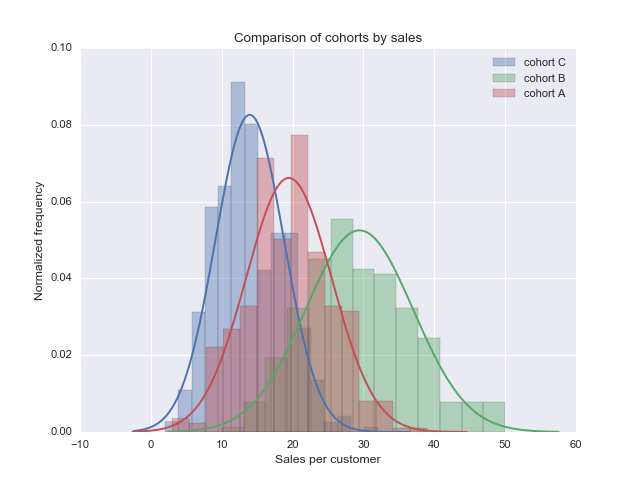

In [26]:
sales_plot = plt.figure(3)

sales_axis = sbn.distplot(total_c, kde=False, fit=sts.norm, fit_kws={'color': '#4c72b0'}, label='cohort C')
sbn.distplot(total_b, kde=False, fit=sts.norm, fit_kws={'color': '#55a868'}, label='cohort B')
sbn.distplot(total_a, kde=False, fit=sts.norm, fit_kws={'color': '#c44e52'}, label='cohort A')

sales_axis.set_xlabel('Sales per customer')
sales_axis.set_ylabel('Normalized frequency')
sales_axis.set_title('Comparison of cohorts by sales')
sales_axis.legend();

In [27]:
sbn.color_palette().as_hex()

['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd']

#### It looks like we have a winner. But are the differences between cohorts statistically significant? Again, we need to test for this, proceeding in a stepwise fashion as before.

### Check for normality

#### Let's first visually inspect our sales distributions against Gaussians in Q-Q plots

<IPython.core.display.Javascript object>


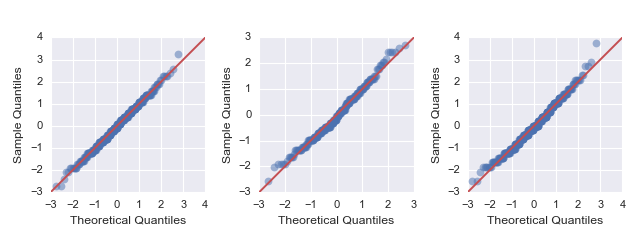

In [28]:
qq_norm_fig = plt.figure(4, figsize=(8, 3))

qq_axis_a = qq_norm_fig.add_subplot(131, aspect=1.0)
qq_axis_b = qq_norm_fig.add_subplot(132, aspect=1.0)
qq_axis_c = qq_norm_fig.add_subplot(133, aspect=1.0)

sm.qqplot(total_a, dist=sts.norm, fit=True, line='45', ax=qq_axis_a)
sm.qqplot(total_b, dist=sts.norm, fit=True, line='45', ax=qq_axis_b)
sm.qqplot(total_c, dist=sts.norm, fit=True, line='45', ax=qq_axis_c)

lines = qq_norm_fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
dots  = qq_norm_fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[l.set_color('#c44e52') for l in lines]
[d.set_color('#4c72b0') for d in dots ]
[d.set_alpha(0.5)       for d in dots ]

plt.tight_layout()

#### That looks pretty OK, despite the fact that our distributions are not really all that Gaussian. What do the numbers say?

In [29]:
print('COHORT A')
print(sts.normaltest(total_a))
print('ShapirotestResult: ', sts.shapiro(total_a))
print(sts.anderson(total_a), '\n')

print('COHORT B')
print(sts.normaltest(total_b))
print('ShapirotestResult: ', sts.shapiro(total_b))
print(sts.anderson(total_b), '\n')

print('COHORT C')
print(sts.normaltest(total_c))
print('ShapirotestResult: ', sts.shapiro(total_c))
print(sts.anderson(total_c))

COHORT A
NormaltestResult(statistic=0.59999759784938766, pvalue=0.74081911046072335)
ShapirotestResult:  (0.9959573745727539, 0.49730968475341797)
AndersonResult(statistic=0.519943496265455, critical_values=array([ 0.57 ,  0.649,  0.778,  0.908,  1.08 ]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ])) 

COHORT B
NormaltestResult(statistic=4.5224813505703443, pvalue=0.10422109996618534)
ShapirotestResult:  (0.9874842166900635, 0.0271601565182209)
AndersonResult(statistic=0.92821863362203771, critical_values=array([ 0.567,  0.646,  0.775,  0.904,  1.075]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ])) 

COHORT C
NormaltestResult(statistic=6.2156920134116005, pvalue=0.044697129040560481)
ShapirotestResult:  (0.9890226721763611, 0.004854057915508747)
AndersonResult(statistic=1.2089658305442867, critical_values=array([ 0.57 ,  0.649,  0.779,  0.909,  1.081]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


#### Not so OK. The _Anderson_ test rejects the normality of cohort A and B, while the _Shapiro_ test rejects normality of cohort C. Better keep on the safe side and not use _Bartlett_.

### Check for equal variance

In [30]:
print(sts.levene(total_a, total_b, total_c, center='median'), '\n')

print('FlignerResult: ', sts.fligner(total_a, total_b, total_c, center='median'))

LeveneResult(statistic=32.46599467807232, pvalue=2.1894230657402449e-14) 

FlignerResult:  FlignerResult(statistic=59.901517773124212, pvalue=9.8299359203602049e-14)


#### Both tests reject the null hypothesis of equal variance quite confidently. Because of the unequal variance, your vanilla ANOVA is not on. We'll have to use Welch's ANOVA or _Kuskal-Wallis_.

### Test for significance of differences in total sales between cohorts

In [31]:
print(welch_anova(total_a, total_b, total_c))
sts.kruskal(total_a, total_b, total_c)

WelchAnovaResult(F_statistic=431.42541778239615, p_value=7.2791474324758176e-114)


KruskalResult(statistic=489.4382832490781, pvalue=5.2459865932301218e-107)

#### So the cohort means are indeed significantly different by any measure. What we need to do next is a _post-hoc_ test to determine which cohort differs from which. Unfortunately, the way to go after the Kruskal-Wallis test, _Dunn's test_, is not implemented in python. This leaves us with the Games-Howell test, which is the appropriate thing to go for after Welch's ANOVA.

In [32]:
games_howell(total_a, total_b, total_c, alpha=0.05)

,0,1,2
0,-,9.963E+00 | 1.356E+00,5.518E+00 | 9.455E-01
1,True,-,1.548E+01 | 1.266E+00
2,True,True,-


#### Indeed, in pairwise comparison, all three cohorts differ from each other to a significant extent and this concludes the answer to the question which cohort is best in terms of total sales: It is cohort B, followed by A, followed by C.

In [33]:
del total_a
del total_b
del total_c

## What (if Anything) Makes Cohort B Special?

### Let's look at the relative frequencies of the customer attributes in each cohort

In [34]:
full_data.loc[:, :'hph'].query('cohort == "a"').mean()

hfn    0.606742
hln    0.834270
hve    0.477528
hph    0.323034
dtype: float64

In [35]:
full_data.loc[:, :'hph'].query('cohort == "b"').mean()

hfn    0.642857
hln    0.869048
hve    0.960317
hph    0.301587
dtype: float64

In [36]:
full_data.loc[:, :'hph'].query('cohort == "c"').mean()

hfn    0.614796
hln    0.859694
hve    0.293367
hph    0.244898
dtype: float64

#### The main difference between cohorts seems to be that the fraction of customers, which provided a verified email address, is largest in cohort B, smaller in cohort A and smallest in cohort C. Before we go any further, though, let's see if these differences are significant.

### Test the null hypothesis that the fractions of customers with email are all the same and just differ by chance.

In [37]:
hve_a = full_data.query('cohort == "a"').hve
hve_b = full_data.query('cohort == "b"').hve
hve_c = full_data.query('cohort == "c"').hve

ct = ([[hve_a.sum(), hve_b.sum(), hve_c.sum()],
       [hve_a.count() - hve_a.sum(), hve_b.count() - hve_b.sum(), hve_c.count() - hve_c.sum()]])

print('p-value: ', sts.chi2_contingency(ct, lambda_='log-likelihood')[1])

del hve_a
del hve_b
del hve_c
del ct

p-value:  8.02781056403e-73


#### That is not the case. So let's do a pairwise comparison as _post-hoc_ test with _p_-values corrected for family-wise error.

In [38]:
bool_groups('hve', 'cohort', full_data, alpha=0.05, method='hommel')
# method = bonferroni, sidak, holm-sidak, holm, simes-hochberg, hommel, fdr_bh, fdr_by, fdr_tsbh, fdr_tsbky

,group1,group2,pval,pval_corr,reject
1,c,a,2.71898e-07,2.71898e-07,True
2,c,b,3.0455e-72,9.13649e-72,True
3,a,b,3.84821e-42,7.69643e-42,True


#### Indeed, the fraction of customers providing email addresses differs significantly between all cohorts. This observation suggests the hypothesis that customers, who have a valid email address, bought more stuff regardless of which cohort they were in (some sort of promo action?).

### Let's look at a factor plot to see whether providing an email makes you buy more stuff irrespective of cohort.

<IPython.core.display.Javascript object>


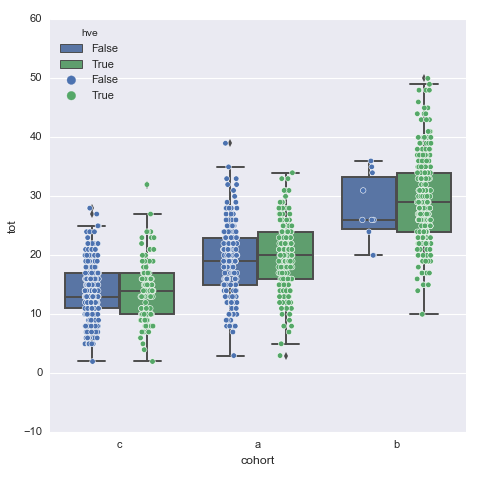

In [39]:
sbn.factorplot(x='cohort', y='tot', hue='hve', data=full_data, 
               kind='box', size=6, legend_out=False)
sbn.stripplot(x='cohort', y='tot', hue='hve', data=full_data, 
              jitter=True, split=True, edgecolor='white', linewidth=0.5);

#### Hmm. Not really. Looks like have's and have not's are pretty much the same within each cohort.

### Can we reject the hypothesis that have's and have not's within one cohort are from the same population?

In [40]:
haves = full_data.query('cohort == "b" and hve == True').tot      # or "a" or "c"
havenots = full_data.query('cohort == "b" and hve == False').tot  # or "a" or "c"

print(sts.ks_2samp(haves, havenots))
print(sts.mannwhitneyu(haves, havenots))
print(sts.levene(haves, havenots, center='median'))
print('FlignerResult',sts.fligner(haves, havenots, center='median'))
print(sts.ttest_ind(haves, havenots, equal_var=True))

del haves
del havenots

Ks_2sampResult(statistic=0.20743801652892557, pvalue=0.75220939581643398)
MannwhitneyuResult(statistic=1068.5, pvalue=0.26603645393634873)
LeveneResult(statistic=1.2681963074949181, pvalue=0.2611851808838998)
FlignerResult FlignerResult(statistic=1.0622829917135901, pvalue=0.30269506449699635)
Ttest_indResult(statistic=0.69135540522411432, pvalue=0.48998371204763436)


#### Nope! Having remembered that not all cohorts were particularly Gaussian distributed, we could neither reject the null-hypothesis of same population, nor same variance, nor same mean, nor same anything really. So, providing an email does _not_ make you buy more stuff overall. Being in a different cohort does. Since a _two-way ANOVA_ (checking for interactions between email and cohort) for unequal variances and pretty unbalanced sample sizes is not available in python, we will leave our analysis of the cumulative sales data at that and move on. 

## The time evolution of sales

### Let's first plot the sales per week

<IPython.core.display.Javascript object>


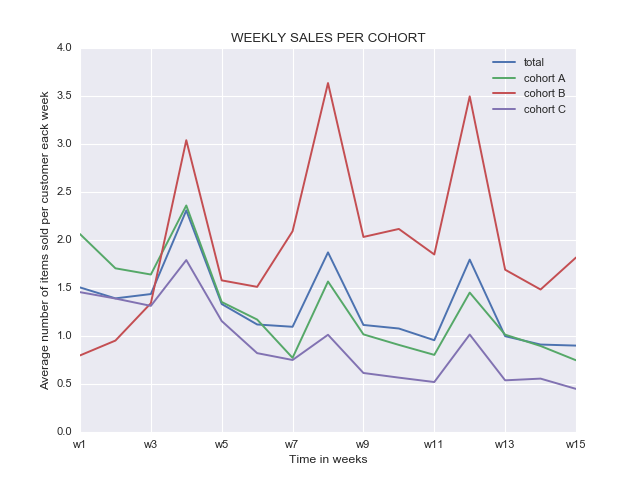

In [119]:
weekly_sales_a = full_data.query('cohort == "a"').mean()['w1':]
weekly_sales_b = full_data.query('cohort == "b"').mean()['w1':]
weekly_sales_c = full_data.query('cohort == "c"').mean()['w1':]

weekly_sales_tot = full_data.mean()[6:]

weekly_plot = plt.figure(6)

weekly_axis = weekly_sales_tot.plot(label='total')
weekly_sales_a.plot(label='cohort A')
weekly_sales_b.plot(label='cohort B')
weekly_sales_c.plot(label='cohort C')

weekly_axis.set_xlabel('Time in weeks')
weekly_axis.set_ylabel('Average number of items sold per customer eack week')
weekly_axis.set_title('WEEKLY SALES PER COHORT')
weekly_axis.legend()

del weekly_sales_a
del weekly_sales_b
del weekly_sales_c

#### There seems to be a four-weekly spike in sales, which might rationalize some of the non-normality of the total-sales distribution(s). Let's look at the weekly data in some more detail, focusing, for example, on the period of week 5 to week 8.

<IPython.core.display.Javascript object>


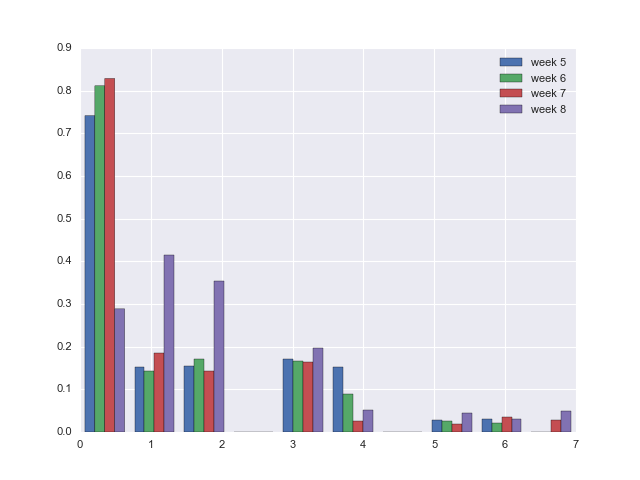

In [120]:
weekly_hist = plt.figure(7)
weekly_hist_ax = weekly_hist.add_subplot(111)
weekly_hist_ax.hist([full_data.w5, full_data.w6, full_data.w7, full_data.w8], normed=True)
weekly_hist_ax.legend(['week 5', 'week 6', 'week 7', 'week 8'])
plt.show()

#### Looking at the histograms suggests that it is not so much _all_ customers buying _more_ stuff in weeks 4, 8 and 12 rather than _more_ customers buying _some_ stuff. Let's check this explicitly.

<IPython.core.display.Javascript object>


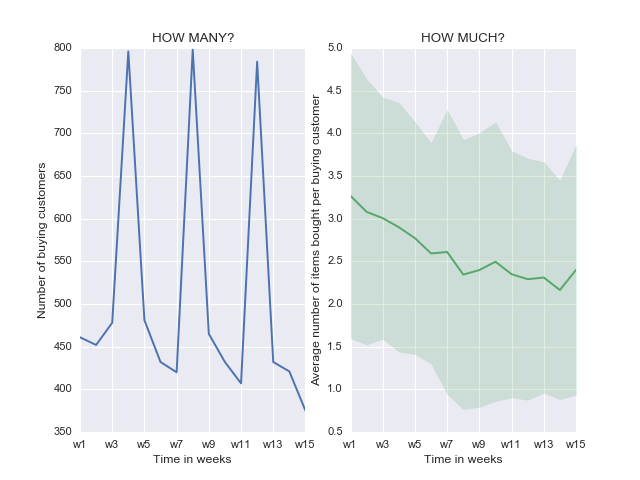

In [121]:
bool_mask = full_data.loc[:, 'w1':].ne(0)
average = full_data.loc[:, 'w1':].sum() / bool_mask.sum()
std_dev = np.sqrt((((full_data.loc[:, 'w1':] - average)**2) * bool_mask).sum() / bool_mask.sum())

spike_fig = plt.figure(8)

number_axis = spike_fig.add_subplot(121)
bool_mask.sum().plot()
number_axis.set_ylabel('Number of buying customers')
number_axis.set_xlabel('Time in weeks')
number_axis.set_title('HOW MANY?')

average_axis = spike_fig.add_subplot(122)
average.plot(color='#55a868')
average_axis.fill_between(range(average.count()), average-std_dev, average+std_dev, alpha=0.2, color='#55a868')
average_axis.set_ylabel('Average number of items bought per buying customer')
average_axis.set_xlabel('Time in weeks')
average_axis.set_title('HOW MUCH?')

del average
del std_dev

#### Indeed, it is the number of buying customers that is responsible for the pronounced spikes in sales every four weeks, while the average number of items declines somewhat. The final question is, then, whether we can identify any characterizing traits of those customers, who spontanously decide to buy at least some stuff in weeks 4, 8 and 12.

#### To approach this question, we first split customers into as many groups as there are combinations of attributes and cohorts (turns out there are 44) an plot how many of each group buy in each week.

### Plot number of weekly buyers broken down by customer groups

<IPython.core.display.Javascript object>


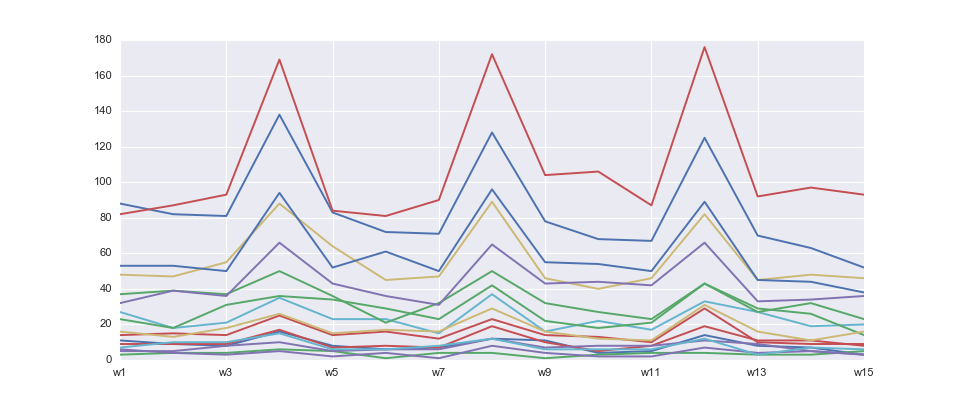

In [148]:
categories = ['hfn', 'hln', 'hve', 'hph']
grouped_data = full_data.groupby(categories)
group_fig = plt.figure(9, figsize=(12,5))
for name, groups in grouped_data:
    groups.loc[:, 'w1':].ne(0).sum().plot()

#### Hmmm. Not very concluive. It looks like pretty much every customer group spontanously decides to buy more stuff every four weeks.

### One-sided hypergeomoetric test on boolean attributes

#### To dig for numbers, what we would like to do next for each week, is to determine how many of each group buy stuff. Then, we could potentially check whether the observed counts differ significantly from values that could be expected when randomly picking the total number of customers each week. Unfortunately, there are two problems with this approach:

#### The first is that some of the groups are relatively small and contain no more than, say, 3 individuals. This is too few for any statisitcal test on frequencies of occurrance to yield reliable results. Even when keeping the duplicates, we thus seem to have too few customers in the study and we will, therefore, have to pool some of the groups.

#### The second problem is that the number of buyers in each week can get up to 80% of the total number of individuals in the study. This would have to be taken into account, when assessing the probability of the observed proportions, _i.e._, we would need to test against randomly picking customers _without replacement_. This, however, calls for a _multivariate hypergeometric test_, which is neither available nor easy to implement efficiently.

#### The only thing we can do, therefore, is to use a _hypergeometric_ test, which means that we can only test for differences between two groups of customers at a time. More specifically, we are going to use a one-sided version, meaning we compute the cdf, if the observed fraction is below its expected value and the survival function (sf), if it is above.

<IPython.core.display.Javascript object>


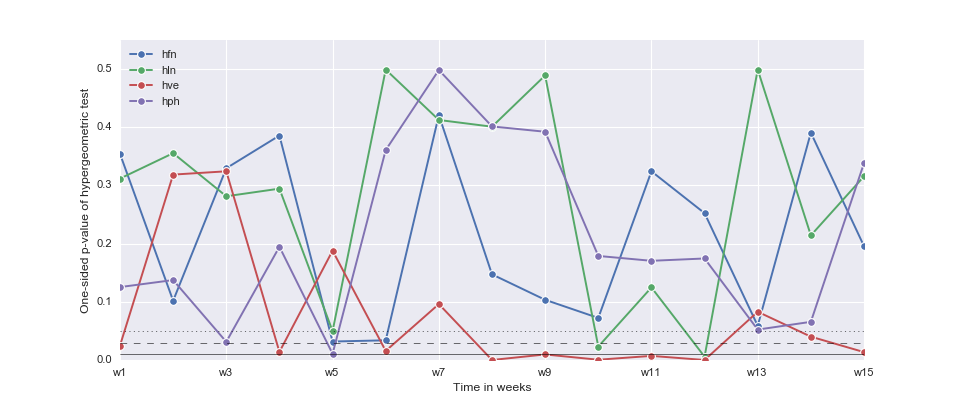

In [146]:
categories = full_data.columns[1:5]

test_fig = plt.figure(10, figsize=(12,5))

for category in categories:
    tot_count = full_data.groupby(category).size().loc[True]
    week_count = full_data.loc[:, :'hph'].join(bool_mask).groupby(category).sum().loc[:, 'w1':]

    pvals=pd.Series(index=week_count.keys())

    for week in week_count.keys():
        dist = sts.hypergeom(M=full_data.count()[0], n=tot_count, N=week_count.sum()[week])
        if (week_count.loc[True, week] < dist.mean()):
            pvals[week] = dist.cdf(week_count.loc[True, week])
        else:
            pvals[week] = dist.sf(week_count.loc[True, week])

    pval_axis = pvals.plot(label=category, ylim=(0.0, 0.55), 
                           marker='o', markeredgewidth=1, markeredgecolor='white')
pval_axis.axhline(0.01, color='k', linewidth=0.5)
pval_axis.axhline(0.03, color='k', linewidth=0.5, linestyle='--')
pval_axis.axhline(0.05, color='k', linewidth=0.5, linestyle='dotted')
pval_axis.legend(loc='upper left')
pval_axis.set_xlabel('Time in weeks')
pval_axis.set_ylabel('One-sided p-value of hypergeometric test');

#### Some _p_-values are suspiciously low indeed, at least in some weeks. The overall picture, however, remains far from clear as no four-weekly periodicity is observed. Yet another way of looking at things is to check, whether category counts are outside a confidence interval around the expected median in each week.

### Check for outliers in the counts of categories

In [147]:
alpha = 0.01
categories = ['hfn', 'hln', 'hve', 'hph']

suspicion = pd.DataFrame(index=categories, columns=full_data.keys()[7:])

for cat in categories:
    
    tot_count = full_data.groupby(cat).size().loc[True]
    week_count = full_data.loc[:, :'hph'].join(bool_mask).groupby(cat).sum().loc[:, 'w1':]
    
    for week in week_count.keys():
        dist = sts.hypergeom(M=full_data.count()[0], n=tot_count, N=week_count.sum()[week])
        if (week_count.loc[True, week] < min(dist.interval(1.0 - alpha))):
            suspicion.loc[cat, week] = 'too few'
        elif (week_count.loc[True, week] > max(dist.interval(1.0 - alpha))):
            suspicion.loc[cat, week] = 'too many'
        else:
            suspicion.loc[cat, week] = 'ok'

suspicion

,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
hfn,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok
hln,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok
hve,ok,ok,ok,ok,ok,ok,ok,too many,ok,too many,ok,too many,ok,ok,ok
hph,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok


#### Narrowing things down a bit by increasing the confidence level to 0.99 reveals that in weeks 8, 10 and 12, there are conspicously many cutomers with valid email addresses among those who bought stuff in these weeks. Not in week 4 though. Consequently, no clear picture emerges from thios point of view either. Finally, there appears to be no impact whatsoever of "watching" items.

In [53]:
del alpha
del bool_mask
del cat
del categories
del dist
del grouped_data
del groups
del name
del pvals
del tot_count
del week
del week_count
del suspicion

# THE END